# Initialization

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
import torch.nn as nn
import torchvision
from pkg_resources import packaging
import matplotlib.pyplot as plt
import clip
from PIL import Image
import os
from glob import glob
from tqdm import tqdm

In [ ]:
# load the CLIP model and freeze all its parameters

model, preprocess = clip.load("RN50x4")
model.eval()
model.trainable = False
m = model.requires_grad_(False)

100%|███████████████████████████████████████| 402M/402M [00:04<00:00, 86.4MiB/s]


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Download some images from drive and classify them in folders

!wget https://docs.google.com/uc?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5 -O /content/trump1.zip
!wget https://docs.google.com/uc?id=1yUDmA07-519KOpTEHbEebZR8SLrcVhKC -O /content/trump2.zip
!wget https://docs.google.com/uc?id=196fkPNzgoayxlTg06yEf43YO13QLO2YG -O /content/usa.zip
!wget https://docs.google.com/uc?id=1pbkUuPjVtAr6EKJaadBAqk6l6Y-xodZd -O /content/flags.zip
!wget https://docs.google.com/uc?id=1eZS_7seR9j7iSWrKINPfKI9fhKLElVpw -O /content/dogs.zip

!rm -r /content/trump1
!mkdir /content/trump1                              # unzip trump1.zip to new trump1 directory
!unzip /content/trump1.zip -d /content/trump1
trump_files1 = glob(os.path.join('/content/trump1', "**"))   # get the paths of all files in trump1 directory

!rm -r /content/trump2
!mkdir /content/trump2
!unzip /content/trump2.zip -d /content/trump2
trump_files2 = glob(os.path.join('/content/trump2', "**"))

!rm -r /content/usa
!mkdir /content/usa
!unzip /content/usa.zip -d /content/usa
usa_files = glob(os.path.join('/content/usa', "**"))

!rm -r /content/flags
!mkdir /content/flags
!unzip /content/flags.zip -d /content/flags
flags_files = glob(os.path.join('/content/flags', "**"))

!rm -r /content/dogs
!mkdir /content/dogs
!unzip /content/dogs.zip -d /content/dogs
dogs_files = glob(os.path.join('/content/dogs', "**"))

#!rm -r /content/myanimals
#!mkdir /content/myanimals
#!unzip /content/drive/MyDrive/myanimals.zip -d /content/myanimals
#myanimals_files = glob(os.path.join('/content/myanimals/myanimals', "**"))

--2024-03-04 14:31:04--  https://docs.google.com/uc?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5
Resolving docs.google.com (docs.google.com)... 142.251.2.101, 142.251.2.100, 142.251.2.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5 [following]
--2024-03-04 14:31:04--  https://drive.usercontent.google.com/download?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475559 (464K) [application/octet-stream]
Saving to: ‘/content/trump1.zip’

/content/trump1.zip 100%[===================>] 464.41K  --.-KB/s    in 0.1s    

2024-03-04 14:31:06 (3.79 MB/s) - 

# My model

In [ ]:
# Create a model that is the same as clip, having removed its last layers.
# Its output is the input of the last convolution layer, whose activations we want to test
# The code for the original CLIP model can be found in https://github.com/openai/CLIP/blob/main/clip/model.py

from collections import OrderedDict

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, final = False):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        if not final:
          self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
          self.bn3 = nn.BatchNorm2d(planes * self.expansion)
          self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride
        self.final = final

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)

        if not self.final:
          out = self.bn3(self.conv3(out))

          if self.downsample is not None:
            identity = self.downsample(x)

          out += identity
          out = self.relu3(out)
        return out

class MyModifiedResNet(nn.Module):    # I have removed some final layers, up to before the last convolution
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, input_resolution=224, width=64):
        super().__init__()
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2, final = True)

    def _make_layer(self, planes, blocks, stride=1, final = False):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion

        if final:
          blocks -= 1
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        if final:
          layers.append(Bottleneck(self._inplanes, planes, final = True))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

In [ ]:
mymodel = MyModifiedResNet([4,6,10,6], width = 80)   # these are the parameters used in CLIP RN50x4
mymodel.load_state_dict(model.visual.state_dict(), strict = False, assign = True)    # copy model parameters
mymodel.cuda()
mymodel.trainable = False       # freeze mymodel parameters, and enter evaluation mode
mymodel.eval()
m = mymodel.requires_grad_(False)

In [ ]:
convlayer = model.visual.layer4[5].conv3.half()
param_tensor = list(convlayer.parameters())[0]   # get last conv layer parameters
print(param_tensor.shape)
param_tensor = param_tensor.mean(dim = (2,3))    # set their dimension to 2560x640, we have 2560 filters of dimension 640 (x1x1)
print(param_tensor.shape)

torch.Size([2560, 640, 1, 1])
torch.Size([2560, 640])


# Which neurons activate?

In [ ]:
# get the images stimulating the most each neuron

def get_most_responding_neurons(files, tops = 5):
  output = []
  for filename in tqdm(files):           # open and process every image file, add it to input, and add the model output in output
    photo = Image.open(filename)
    photo_vec = preprocess(photo)
    input = torch.stack([photo_vec]).cuda()

    with torch.no_grad():
      output.append(mymodel(input)[0])
  output = torch.stack(output)

  # get the max neural activation for each neuron
  neural_activation = param_tensor @ output.T   # neural activation shape is [9, 9, 2560, filecount]
  neural_activation_max = neural_activation.max(dim=0)[0].max(dim=0)[0]

  tops = neural_activation_max.topk(tops, dim = 1).indices  # return the top neurons for each image
  return tops, neural_activation_max

In [ ]:
#print("trump1\n", get_most_responding_neurons(trump_files1))
#print("\ntrump2\n", get_most_responding_neurons(trump_files2))
#print("\nusa\n", get_most_responding_neurons(usa_files))
#print("\nflags\n", get_most_responding_neurons(flags_files))
#print("\ndogs\n", get_most_responding_neurons(dogs_files))

tops, activations = get_most_responding_neurons(trump_files1)

100%|██████████| 6/6 [00:00<00:00, 36.09it/s]


tensor([0, 4, 5, 1, 3], device='cuda:0')


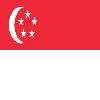

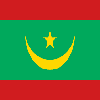

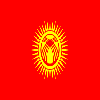

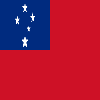

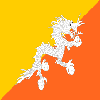

In [ ]:
# get the images that stimulate neuron 89 the most

print(tops[89])
for i in tops[89]:
  image = Image.open(flags_files[i]).resize((100,100))
  display(image)